# Bayesian Fama-French Factor Model

### Data Settings

In [32]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
data_path = 'simulation_data'

start_date = '2016-03-30'
end_date = '2025-03-20'
with open(f"{data_path}/KS200_MASK.pkl", 'rb') as f:
    mask_df:pd.DataFrame = pickle.load(f).ffill(axis=1)
    mask_df = mask_df.loc[:, start_date:end_date]
with open(f"{data_path}/Return.pkl", 'rb') as f:
    returns_df = pickle.load(f).ffill(axis=1) * 0.01
    returns_df = returns_df.loc[:, start_date:end_date]
with open(f"{data_path}/MarketCap.pkl", 'rb') as f:
    mc_df = pickle.load(f).ffill(axis=1)
    mc_df = mc_df.loc[:, start_date:end_date]
with open(f"{data_path}/ifrs-full_Equity.pkl", 'rb') as f:
    be_df = pickle.load(f).ffill(axis=1)
    be_df = be_df.loc[:, start_date:end_date]
with open(f"{data_path}/KOSPI_Close.pkl", 'rb') as f:
    kospi_close_df = pickle.load(f).ffill(axis=1)
    kospi_return_df = kospi_close_df.pct_change(axis=1)
    mkt_df = kospi_return_df.loc[:, start_date:end_date]
with open(f"{data_path}/rf_bond.pkl", 'rb') as f:
    rf_df = pickle.load(f).ffill(axis=1) * 0.01
    rf_df = rf_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_aa_bond.pkl", 'rb') as f:
    corp_aa_df = pickle.load(f).ffill(axis=1) * 0.01
    corp_aa_df = corp_aa_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_bb_bond.pkl", 'rb') as f:
    corp_bb_df = pickle.load(f).ffill(axis=1) * 0.01
    corp_bb_df = corp_bb_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov10_bond.pkl", 'rb') as f:
    gov10_df = pickle.load(f).ffill(axis=1) * 0.01
    gov10_df = gov10_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov3_bond.pkl", 'rb') as f:
    gov3_df = pickle.load(f).ffill(axis=1) * 0.01
    gov3_df = gov3_df.loc[:, start_date:end_date]
corp_df = (corp_aa_df + corp_bb_df) / 2

In [3]:
R     = returns_df
MC    = mc_df
BE    = be_df 
RF = rf_df / 252 # 일단위 reblancing 시행하므로 252로 나누어 줌.
GOV10   = gov10_df / 252
GOV3 = gov3_df / 252
CORP  = corp_df / 252
MKT   = mkt_df
mask  = mask_df.astype(bool)

dates = R.columns
tickers = R.index

In [23]:
port_rets = {f"S{i}B{j}":[] for i in range(1,6) for j in range(1,6)}

for dt in dates:
    members = mask[dt][mask[dt]].index
    if members.empty: 
        continue

    # size quintile breakpoints
    me = MC.loc[members, dt].dropna()
    sz_br = me.quantile([0.2,0.4,0.6,0.8]).values

    # BE/ME quintile breakpoints
    bm = (BE.loc[members, dt] / MC.loc[members, dt]).dropna()
    bm_br = bm.quantile([0.2,0.4,0.6,0.8]).values

    # 각 포트폴리오
    for i in range(1,6):
        size_idx = me[
            (me >  (sz_br[i-2] if i>1 else -np.inf)) &
            (me <= (sz_br[i-1] if i<5 else  np.inf))
        ].index
        for j in range(1,6):
            bm_idx = bm[
              (bm >  (bm_br[j-2] if j>1 else -np.inf)) &
              (bm <= (bm_br[j-1] if j<5 else  np.inf))
            ].index

            idx = size_idx.intersection(bm_idx)
            name = f"S{i}B{j}"
            if idx.empty:
                ret = np.nan
            else:
                w = MC.loc[idx, dt]
                w = w / w.sum()
                ret = (R.loc[idx, dt] * w).sum()
            port_rets[name].append((dt, ret))

# DataFrame으로 변환
port_df = pd.DataFrame({
    name: pd.Series(dict(port_rets[name]))
    for name in port_rets
}).sort_index(axis=1)
port_df = port_df.interpolate(method='linear', axis=0, limit_direction='both')


# ── 2) SMB, HML 계산 ──
# SMB: size quintile 1 평균 – quintile 5 평균
SMB = (port_df[[f"S1B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S2B{j}" for j in range(1,6)]].mean(axis=1)) \
        - (port_df[[f"S5B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S4B{j}" for j in range(1,6)]].mean(axis=1)) 

# HML: BE quintile 5 평균 – quintile 1 평균
HML = (port_df[[f"S{i}B5" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B4" for i in range(1,6)]].mean(axis=1))\
     - (port_df[[f"S{i}B1" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B2" for i in range(1,6)]].mean(axis=1))


factors = pd.DataFrame({
    'MKT_RF': MKT.iloc[0] - RF.iloc[0],
    'SMB':     SMB,
    'HML':     HML,
    'TERM':    GOV10.iloc[0]  - RF.iloc[0],
    'DEF':     CORP.iloc[0] - GOV3.iloc[0],
    'RF':      RF.iloc[0]
}, index=dates).dropna()

In [24]:
factors

,MKT_RF,SMB,HML,TERM,DEF,RF
2016-03-30,0.003560,-0.004864,-0.008255,0.000007,0.000138,0.000064
2016-03-31,-0.003206,0.012003,-0.004497,0.000007,0.000138,0.000064
2016-04-01,-0.011227,0.021868,-0.009723,0.000007,0.000138,0.000064
2016-04-04,0.002672,-0.002250,-0.021757,0.000006,0.000138,0.000064
2016-04-05,-0.008265,0.011213,-0.002196,0.000007,0.000138,0.000064
...,...,...,...,...,...,...
2025-03-14,-0.002941,0.001041,-0.004142,-0.000001,0.000137,0.000113
2025-03-17,0.017161,-0.012326,-0.007089,-0.000001,0.000137,0.000113
2025-03-18,0.000519,-0.009031,-0.000572,-0.000002,0.000137,0.000113
2025-03-19,0.006119,0.000945,0.010262,-0.000001,0.000136,0.000113


### Prior Settings
<img align="middle" src="images\bayesian_linear_reg.png" height="400" />

<img align="middle" src="images\g-prior_settings.png" height="400" />

<img align="middle" src="images\model_selection_settings.png" height="400" />

<img align="middle" src="images\steps_for_MCMC.png" height="400" />

My model for Bayesian FF

Y = z_0*beta_0 + z_1*beta_1 * MKT_RF + z_2*beta_2 * SMB + z_3*beta_3 * HML + z_4*beta_4 * TERM + z_5*beta_5 * DEF + e

In [36]:
import numpy as np, pandas as pd
from numpy.linalg import inv
from scipy.special import gammaln, expit
from tqdm.auto import trange

# ────────────────────────────────────────────────────────────────────────────
# 1.  pre-compute log-marginal-likelihood for every mask ∈ {0,1}⁵
#     (intercept 고정이라 5-bit → 32 개 모델)
# ────────────────────────────────────────────────────────────────────────────
def precompute_logml_table(X, y, nu0=1.0, s0_sq=1.0):
    """
    Returns dict:  key = mask (0-31),   value = log p(y|z_mask,X)
    """
    y = y.reshape(-1, 1)
    n     = len(y)
    g     = n
    yTy   = float(y.T @ y)
    XtX   = X.T @ X
    Xty   = X.T @ y

    logml = {}
    for mask in range(32):                     # 5 bits, intercept 고정
        bits   = [(mask >> k) & 1 for k in range(5)]
        cols   = [0] + [i+1 for i,b in enumerate(bits) if b]
        p_z    = len(cols)
        XtX_z  = XtX[np.ix_(cols, cols)]
        Xty_z  = Xty[cols]
        beta_hat = inv(XtX_z) @ Xty_z
        ssr     = yTy - (g / (g+1)) * float(Xty_z.T @ beta_hat)

        t1 = -0.5 * n * np.log(np.pi)
        t2 = -0.5 * p_z * np.log1p(g)
        t3 = gammaln(0.5*(nu0+n)) - gammaln(0.5*nu0)
        t4 = 0.5*nu0*np.log(nu0*s0_sq)
        t5 = -0.5*(nu0+n)*np.log(nu0*s0_sq + ssr)
        logml[mask] = t1+t2+t3+t4+t5
    return logml

# ────────────────────────────────────────────────────────────────────────────
# 2.  super-fast Gibbs sampler using the logml table
# ────────────────────────────────────────────────────────────────────────────
def fast_gibbs_vs_gprior(X, y, *,
                         n_iter=15_000, burn_in=5_000,
                         prior_pi=0.5, rng=None, bar=False):
    if rng is None:
        rng = np.random.default_rng()
    y = y.squeeze()
    table = precompute_logml_table(X, y)                  # 32 × once
    log_pi   = np.log(prior_pi)
    log_1mpi = np.log1p(-prior_pi)

    mask = rng.integers(0, 32)            # random start
    saved = []
    iterator = trange(n_iter, desc="Gibbs", disable=not bar)
    for _ in iterator:
        for j in rng.permutation(5):      # toggle bit j
            bit = 1 << j
            mask1 = mask |  bit
            mask0 = mask & ~bit
            log_odds = (log_pi - log_1mpi) + table[mask1] - table[mask0]
            if rng.random() < expit(log_odds):
                mask = mask1
            else:
                mask = mask0
        if _ >= burn_in:
            saved.append(mask)
    saved = np.array(saved)
    # posterior inclusion prob for each of 5 factors
    probs = np.zeros(5)
    for j in range(5):
        probs[j] = ((saved >> j) & 1).mean()
    return probs, saved

def fast_gibbs_multi(X, Y, **kw):
    Y = np.asarray(Y)
    if Y.ndim == 1: Y = Y.reshape(-1,1)
    m = Y.shape[1]
    rng = np.random.default_rng(kw.pop("random_state", None))
    probs = []; masks = []
    for k in trange(m, desc="Assets"):
        p_k, ms = fast_gibbs_vs_gprior(X, Y[:,k], rng=rng, bar=False, **kw)
        probs.append(p_k); masks.append(ms)
    return np.vstack(probs), masks

# ────────────────────────────────────────────────────────────────────────────
# 3.  run  (변수 factors, port_df 는 그대로 사용)
# ────────────────────────────────────────────────────────────────────────────
factor_cols   = factors.columns.drop('RF')
X = np.c_[np.ones(len(factors)), factors[factor_cols].to_numpy()]
Y = port_df.subtract(factors['RF'], axis=0).to_numpy()
response_cols = port_df.columns

post_prob, _ = fast_gibbs_multi(
    X, Y,
    n_iter=15_000,
    burn_in=5_000,
    prior_pi=0.5,
    random_state=42
)

# ────────────────────────────────────────────────────────────────────────────
# 4.  결과
# ────────────────────────────────────────────────────────────────────────────
feature_names = factor_cols.tolist()
results = pd.DataFrame(post_prob, columns=feature_names, index=response_cols)
print(results.round(3))


Assets: 100%|██████████| 25/25 [00:04<00:00,  5.68it/s]

      MKT_RF    SMB    HML   TERM    DEF
S1B1     1.0  1.000  1.000  0.020  0.026
S1B2     1.0  1.000  0.946  0.022  0.020
S1B3     1.0  1.000  0.171  0.020  0.024
S1B4     1.0  1.000  1.000  0.028  0.020
S1B5     1.0  1.000  1.000  0.020  0.023
S2B1     1.0  1.000  1.000  0.021  0.021
S2B2     1.0  1.000  0.092  0.024  0.022
S2B3     1.0  1.000  0.902  0.020  0.023
S2B4     1.0  1.000  1.000  0.023  0.023
S2B5     1.0  1.000  1.000  0.022  0.020
S3B1     1.0  1.000  1.000  0.038  0.026
S3B2     1.0  1.000  0.095  0.020  0.021
S3B3     1.0  1.000  1.000  0.026  0.024
S3B4     1.0  1.000  1.000  0.019  0.026
S3B5     1.0  1.000  1.000  0.021  0.021
S4B1     1.0  0.090  1.000  0.030  0.026
S4B2     1.0  0.029  0.510  0.022  0.020
S4B3     1.0  0.083  1.000  0.022  0.020
S4B4     1.0  0.591  1.000  0.026  0.019
S4B5     1.0  0.996  1.000  0.020  0.018
S5B1     1.0  0.901  1.000  0.021  0.020
S5B2     1.0  0.931  1.000  0.020  0.020
S5B3     1.0  0.967  0.127  0.022  0.023
S5B4     1.0  0.

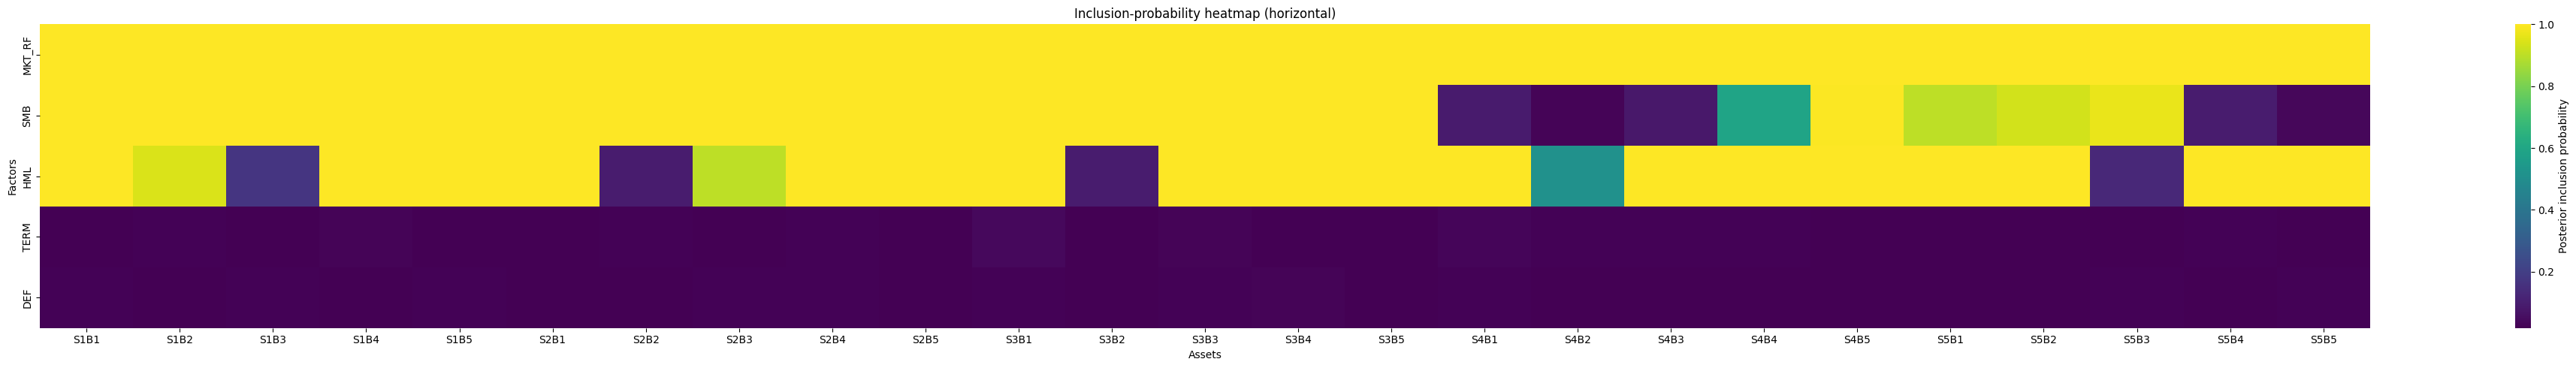

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# transpose so factors are rows and assets are columns
res_T = results.T

fig, ax = plt.subplots(figsize=(1.5 * res_T.shape[1] + 2, 0.6 * res_T.shape[0] + 2))
sns.heatmap(res_T, annot=False, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Posterior inclusion probability'})

# axis labels & title
ax.set_xlabel('Assets')
ax.set_ylabel('Factors')
ax.set_title('Inclusion-probability heatmap (horizontal)')

plt.tight_layout()
plt.show()
